### Лабораторая работа №3 (Численные методы оптимизации)

Сучков В.Н. группа 3821Б1ПМоп1

In [1]:
import optmet as opt
import sympy as sp
import numpy as np
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import seaborn as sns

#### Тестовая функция

In [2]:
x1, x2 = sp.symbols('x_1 x_2', real=True)
q = x1**2 + x2**2 + x1 * x2 - 4
dq1 = sp.Derivative(x1**2 + x2**2 + x1 * x2 - 4, x1, evaluate=True)
dq2 = sp.Derivative(x1**2 + x2**2 + x1 * x2 - 4, x2, evaluate=True)

ddq11 = sp.Derivative(dq1, x1, evaluate=True)
ddq12 = sp.Derivative(dq1, x2, evaluate=True)
ddq21 = sp.Derivative(dq2, x1, evaluate=True)
ddq22 = sp.Derivative(dq2, x2, evaluate=True)

Gess = sp.Matrix([[ddq11, ddq12], [ddq21, ddq22]])
display(q)
display(dq1)
display(dq2)
display(Gess)
qf = sp.lambdify([x1, x2], q)
dqf1 = sp.lambdify([x1, x2], dq1)
dqf2 = sp.lambdify([x1, x2], dq2)

ddqf11 = sp.lambdify([x1, x2], ddq11)
ddqf12 = sp.lambdify([x1, x2], ddq12)
ddqf21 = sp.lambdify([x1, x2], ddq21)
ddqf22 = sp.lambdify([x1, x2], ddq22)

invGess = Gess.inv()
display(invGess)

invGessf = sp.lambdify([x1, x2], invGess)


x_1**2 + x_1*x_2 + x_2**2 - 4

2*x_1 + x_2

x_1 + 2*x_2

Matrix([
[2, 1],
[1, 2]])

Matrix([
[ 2/3, -1/3],
[-1/3,  2/3]])

#### Вид нашей в функции (тепловая карта на плоскости $Ox1x2$)

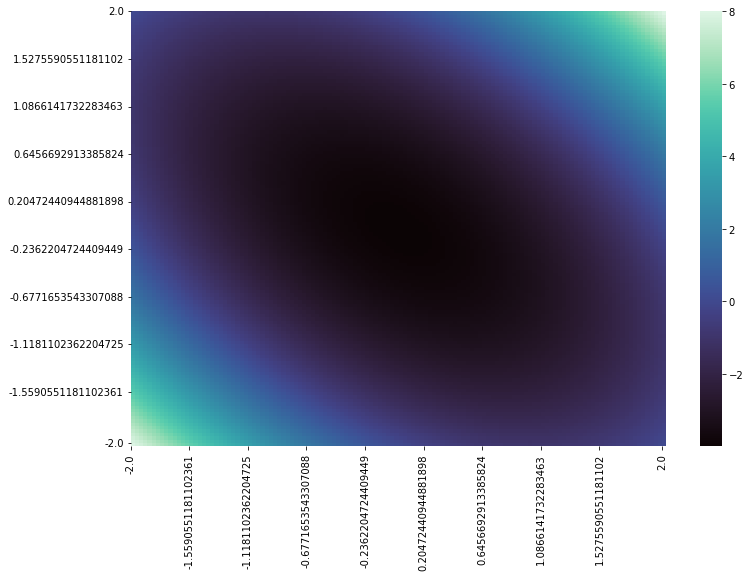

In [3]:
xlims = (-2., 2.)
ylims = (-2., 2.)
n = 128
m = 128

def plotHeatmap(qf, n, m, xlims, ylims, num_ticks):
  stepx = (xlims[1] - xlims[0]) / (n - 1)
  stepy = (ylims[1] - ylims[0]) / (m - 1)
  data = np.empty((n, m))

  
  xvals = np.linspace(xlims[0], xlims[1], n)
  yvals = np.linspace(ylims[0], ylims[1], m)
  yticks = np.linspace(0, m - 1, num_ticks, dtype=int)
  xticks = np.linspace(0, n - 1, num_ticks, dtype=int)
  yticklabels = [yvals[idx] for idx in yticks]
  xticklabels = [xvals[idx] for idx in xticks]

  for j in range(m):
    y = ylims[0] + j * stepy
    for i in range(n):
      x = xlims[0] + i * stepx  
      data[i][m - j - 1] = qf(x, y)

  yticklabels.reverse()
  plt.figure(figsize=(12, 8))
  ax = sns.heatmap(data, cmap='mako')
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticklabels)
  ax.set_yticks(yticks)
  ax.set_yticklabels(yticklabels)


plotHeatmap(qf, n, m, xlims, ylims, 10)
plt.show()

#### **Метод Наискорейшего Градиентного Спуска**

In [10]:

def Q(x):
  return qf(x[0], x[1])
def dQ(x):
  return np.array([dqf1(x[0], x[1]), dqf2(x[0], x[1])])
def invddQ(x):
  return invGessf(x[0], x[1])


P, K = opt.GradDesc(Q, dQ, [-2., -1], 1e-5)
print(P)
print(Q(P))
print(K)

[-1.42749386e-06  1.54925619e-06]
-3.999999999997774
7


Видим, что градиентный спуск приходит в точку минимума с большой точностью, но за 7 шагов (казалось бы, немало, для квадратичной функции). Это связанно с погрешностью вычисления минимума функции в направлении (в этом методе и далее важный ньюанс), а так же с видом самой функиции, а именно, с различием между наибольшим и наименьшим собственными числами матрицы Гесса для нашей квадратичной функции.

#### **Метод Ньютона**

In [5]:
newtres = opt.Newton(Q, dQ, invddQ, (-2., -1.), 1e-5)
print(newtres)
print(Q(newtres[0]))

(array([0., 0.]), 1)
-4.0


Как и ожидалось, отличная сходимость на квадратичной функции за 1 шаг

#### **Метод Ньютона-Рафсона**

In [6]:
nrfsres = opt.NewtonRafson(Q, dQ, invddQ, (-2., -1.), 1e-5)
print(nrfsres)
print(Q(nrfsres[0]))

(array([-4.65937323e-07, -2.32968662e-07]), 2)
-3.99999999999962


Хороший пример, показывающий, что недостаточно точное решенеие задачи одномерной минимизации при использовании аккуратного поиска может влиять на качество работы метода. Видим, что точность метода упала, как и скорость сходимости в сравнении с обычным методом Ньютона

#### **Метод Флетчера-Ривса**

In [7]:
cgres = opt.ConjGrads(Q, dQ, (-2., -1.), 1e-3)
print(cgres)
print(Q(cgres[0]))

(array([-0.00019802, -0.00022121]), 2)
-3.99999986805302


Метод показывает требуемую сходимость: за два шага для двумерной задачи на квадратичной функции. Точность невилика, опять же, по причине неточности в решении задачи одномерной минимизации

#### **Метод Бройдена-Флетчера-Гольдфабра-Шанно (BFGS)**

In [8]:
bfgsres = opt.BFGS(Q, dQ, (-2., -1.), 1e-3)
bfgsres = (np.array([float(bfgsres[0][0]), float(bfgsres[0][1])]), bfgsres[1])
print(bfgsres)
print(Q(bfgsres[0]))

(array([-6.32179116e-07, -5.67473550e-07]), 4)
-3.9999999999989195


Хорошая сходимость с точностью гораздо лучше требуемой за небольшое число шагов без использования Гессиана.

#### **Метод Хука-Дживса**

In [9]:
orts = [np.array([1., 0.]), np.array([0., 1.])]
hjres = opt.HookeJeevs(Q, (-2., 0.), orts, 1e-3, 0.25)
print(hjres)
print(Q(hjres[0]))

(array([0., 0.]), 23)
-4.0


Быстрой сходимости от метода нулевого порядка не ожидалось, и все же, за 23 быстрых шага метод определил минимум с очень высокой точностью!

### Вывод
В данном простом примере задачи локальной минимизации был проверен ряд методов. Для них, как правило, выполнялись теоретические ожидания, возложенные на них. Одной из важных проблем стало вычисления минимума при аккуратном поиске, который используется в методах повсеместно. Такие неточности приводят к заметным изменениям: снижению точности, замедленной сходимости. Для решения этой проблемы нужно более тщательно подходить к аккуратному поиску, подбирая параметры одномерной минимизации для каждой задачи индивидуально, что в целом не гарантирует избавление от всех проблем.